In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils.datasets import SmilesDataset
from data_utils.graphs import smiles_to_graphs

from graph_transformer import GraphTransformer

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [2]:
dataset = SmilesDataset(
    smiles='/home/jshe/prop-pred/src/data/qm9/smiles.csv', 
    y='/home/jshe/prop-pred/src/data/qm9/norm_y.csv'
)
train_dataset, validation_dataset, test_dataset = random_split(dataset, lengths=(0.8, 0.1, 0.1))

In [3]:
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## Model

In [4]:
hyperparameters = dict(
    numerical_features=5, categorical_features=(9+1, 8+1, 2+1, 2+1), 
    E=64, H=4, D=2, 
    dropout=0.1, 
    out_features=dataset.n_properties, 
)

model = GraphTransformer(**hyperparameters).to(device)

In [6]:
#model.load_state_dict(torch.load('./weights/15.pt', map_location=device))

In [7]:
sum(p.numel() for p in model.parameters())

201807

## Eval

In [8]:
smiles, y_true = next(iter(dataloader))

In [9]:
numerical_node_features, categorical_node_features, edges, padding = smiles_to_graphs(smiles, device=device)

In [10]:
y_pred = model(numerical_node_features.float(), categorical_node_features, edges, padding)

loss = torch.nn.functional.mse_loss(y_pred, y_true)
#score = 1 - (loss * len(y_true) / ((y_true - y_true.mean()) ** 2).sum())

## Visualization

In [11]:
log2 = pd.read_csv('./logs/log2.csv')
log3 = pd.read_csv('./logs/log3.csv')

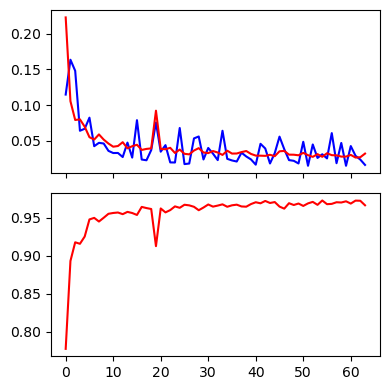

In [12]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(4, 4), sharex=True)

ax0.plot(log3['train_mse'], c='b')
ax0.plot(log3['validation_mse'], c='r')
ax1.plot(log3['validation_r2'], c='r')
#ax1.plot(log2['validation_r2'], c='g')

plt.tight_layout()